## Get some images and import packages

In [1244]:
# if True:      #A weird trick needed for Google Colab
#   # Clone repository with example images 
#   !rm -rf fyp2022-imaging
#   !git clone https://github.com/vcheplygina/fyp2022-imaging.git


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import path


# Load data

In [1245]:
# Load features and labels

file_data = path.ground_truth
file_features = 'data/output/out_rescaled.csv'

features_list = 'color_lesion_r,color_lesion_g,color_lesion_b,color_skin_r,color_skin_g,color_skin_b,area,perimeter,min_symmetry,avg_symmetry,color_variance'.split(',')
log_list = 'color_lesion_r,color_lesion_g,color_lesion_b,area,perimeter,min_symmetry,avg_symmetry,color_variance'.split(',')

df = pd.read_csv(file_data)

features = pd.read_csv(file_features, usecols = ['image_id'] + features_list)

df = df.merge(features, on='image_id')
df = df.drop(['image_id', 'seborrheic_keratosis'],axis=1)
df['circularity'] = (4*np.pi*df['area'])/(df['perimeter'])**2
features_list.append('circularity')
log_list.append('circularity')


df[log_list] = np.log(df[log_list] + 1)

# Combine variables we want in one place
print(df.head())



   melanoma  color_lesion_r  color_lesion_g  color_lesion_b  color_skin_r  \
0       0.0        1.225662        1.509520        1.908902    127.984024   
1       0.0        0.535823        0.774664        1.252889    104.982014   
2       0.0        1.493574        1.710434        1.964830    135.911098   
3       0.0        1.197563        1.410267        1.685368    133.590866   
4       0.0        1.454617        1.820648        2.261048    107.972809   

   color_skin_g  color_skin_b       area  perimeter  min_symmetry  \
0    142.462125    166.470525  15.778111  15.774292      7.497762   
1    139.760681    173.739140  15.272835  15.269028      6.773080   
2    151.329789    158.445620  15.724578  15.720749      6.902743   
3    148.706912    161.939588  15.486085  15.482249      6.378426   
4    135.812584    171.415941  16.159929  16.156078      8.221479   

   avg_symmetry  color_variance  circularity  
0      8.507565         3.84783     0.000002  
1      7.840072         0.00

# Plots of features

<AxesSubplot:>

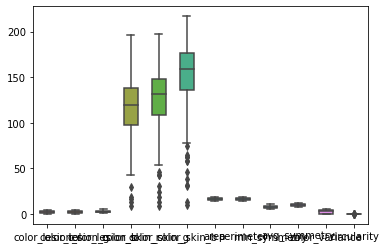

In [1246]:
# Plots of features
import seaborn as sns

df1 = df[features_list]
sns.boxplot(data=df1, width=0.5)



-7.302800339756585e-17
1.0


<AxesSubplot:>

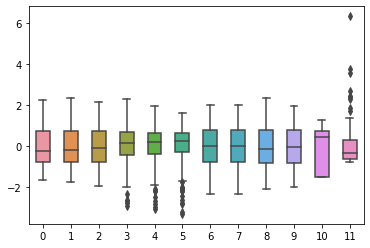

In [1247]:
# Let's scale the features
from sklearn import preprocessing

#Fit scaler on our data
scaler = preprocessing.StandardScaler().fit(df1)

#Apply to data itself
df2 = scaler.transform(df1)

print(df2.mean()) #small number close to 0, round of error
print(df2.var())  #equal to 1 

sns.boxplot(data=df2, width=0.5,fliersize=5) #we see both negative and positive values, since the mean is 0

In [1248]:
# It is possible to do scaling by dividing by the max value, but this can collapse some values together if you have outliers


# original = [0, 0.1, 0.2, ..... 0.8, 10000]
# transformed = original / original.max()





In [1249]:
#print(df2.dtype) #Using the scaler removed the DataFrame information :( so we create it again

df2 = pd.DataFrame(df2,columns=features_list)
df2['melanoma'] = df['melanoma']

# Look at values per class
# sns.pairplot(df2, hue="melanoma", height=3, diag_kind="hist")

In [1250]:
# A plot showing distribution differences for a single feature
# for feature in features_list:
#     fig, ax = plt.subplots()
#     ax = sns.violinplot(x="melanoma", y=feature, data=df2,size=8)

# Feature selection

In [1251]:
# For illustration let's create some noisy features, and see if our method filters them out

random_seed = 42
num_noisy_features = 1

noise = np.random.RandomState(random_seed).uniform(0, 0.1, size=(df2.shape[0], num_noisy_features))

# Add the noisy data to the informative features
X = np.hstack((df2[features_list], noise))
y = df2['melanoma']

num_total_features = df2.shape[1] + num_noisy_features
print(num_total_features)

14


Text(0, 0.5, 'mutual information')

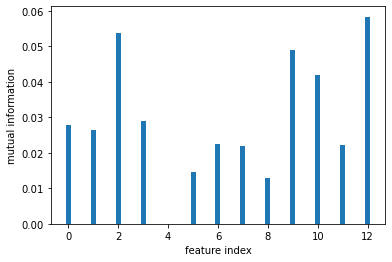

In [1252]:
# Univariate feature selection with mutual information for feature scoring
from sklearn.feature_selection import mutual_info_classif, SelectKBest

selector = SelectKBest(mutual_info_classif, k=11)
selector.fit(X, y)

# Show the feature scores
scores = selector.scores_

fig, ax = plt.subplots()
ax.bar(np.arange(0,num_total_features-1), scores, width=.2)
ax.set_xlabel('feature index')
ax.set_ylabel('mutual information')

In [1253]:
# Use the selector to actually only leave the features with the high scores
X_after_selection = selector.transform(X)

print(X_after_selection.shape)

print(X_after_selection)

(150, 11)
[[-0.88761236 -0.81031907 -0.75679085 ...  0.4735813   0.27439019
   0.03745401]
 [-1.51793137 -1.49217276 -1.35590639 ... -1.54845025  1.00175834
   0.09507143]
 [-0.6428171  -0.62389625 -0.70571356 ... -1.54845025  0.33525636
   0.07319939]
 ...
 [ 1.04590712  1.01532294  0.93898032 ...  0.91239249 -0.69965549
   0.0502679 ]
 [ 0.90746636  0.9639403   1.12150862 ...  1.21272097 -0.70117289
   0.00514788]
 [-0.67414905 -0.35781281  0.10403047 ...  0.66188391 -0.47620193
   0.02786465]]


In [1254]:
from sklearn.model_selection import train_test_split
# Some noisy features

# Add the noisy data to the informative features
X = X_after_selection
# X[:, [9, 10]]



In [1255]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

# Split dataset to select feature and evaluate the classifier
X_dev, X_test, y_dev, y_test = train_test_split(
        X, y, stratify=y, random_state=0)


X_train, X_val, y_train, y_val = train_test_split(
        X_dev, y_dev, stratify=y_dev)

# Train a classifier
knn = KNeighborsClassifier(n_neighbors=15, weights='distance') # other hyperparameters possible
knntrained = knn.fit(X_train, y_train)

dtree = DecisionTreeClassifier()
dtree = dtree.fit(X_train, y_train)

y_val_tree = dtree.predict(X_val)
y_val_knn = knntrained.predict(X_val)

acc_knn = accuracy_score(y_val, y_val_knn)
acc_tree = accuracy_score(y_val, y_val_tree)

auc_knn = roc_auc_score(y_val, y_val_knn)
auc_tree = roc_auc_score(y_val, y_val_tree)

print(acc_knn,auc_knn)
print(acc_tree,auc_tree)

0.8214285714285714 0.5782608695652174
0.8214285714285714 0.6565217391304348


In [1256]:
# ONLY FOR REPORTING, also evaluate on test set
X_test = X_test

y_test_knn = knntrained.predict(X_test)

auc_test = roc_auc_score(y_test, y_test_knn)

print(auc_test)

0.5291666666666667


7.894736842105263


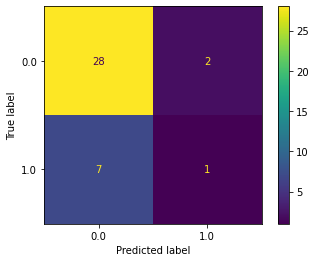

In [1257]:
from sklearn.metrics import ConfusionMatrixDisplay
print(sum(y_test_knn) / len(y_test) * 100)
ConfusionMatrixDisplay.from_predictions(y_test, y_test_knn)